In [1]:
import pandas as pd
import os
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
import pyCloudy as pc
import pyneb as pn

warng pyCloudy config: pyCloudy works better with matplotlib Triangulation


You need to obtain the access code by registering to the Google group: https://groups.google.com/forum/#!forum/3mdb_group

Once you have them, you can store them in Environment Variables, for example from your .cshrc or .bashrc configuration file.

In [2]:
user = os.environ['MdB_USER']
host = os.environ['MdB_HOST']
passwd = os.environ['MdB_PASSWD']
db = os.environ['MdB_DB_17']
port = '3306'

In [3]:
# Compute some line ratios from the observation paper by Parker et al, 2011
RO_obs = (4.7+3.1) / 854
RS_obs = (49.+40) / 5.9
RO3_obs = 28./854
RN2_obs = 8.5/453
print(RO_obs, RS_obs, RO3_obs, RN2_obs)

0.009133489461358314 15.084745762711863 0.03278688524590164 0.018763796909492272


In [4]:
# Look for the models that fit some lines from the 3MdB database
request = """SELECT 
N as ID,
file,
OXYGEN as O,
NITROGEN as N,
logU_mean,
Hbfrac,
atm1 as teff,
lumi,
dens,
radius,
HE_2_468564A / H__1_486133A as HeII,
BLND_732500A/O__3_500684A as RO,
(S__2_671644A+S__2_673082A)/S__3_631206A as RS,
BLND_436300A/O__3_500684A as RO3,
BLND_575500A/N__2_658345A as RN2,
O__3_500684A/H__1_486133A as O3,
N__2_658345A/H__1_486133A as N2
FROM tab_17 
WHERE ref like 'PNe_2020' 
AND abs(HE_2_468564A/H__1_486133A - 0.7) / 0.7 < 0.4
AND abs(BLND_732500A/O__3_500684A - 0.00913) / 0.00913 < 0.4 
AND abs((S__2_671644A+S__2_673082A)/S__3_631206A - 15.1 ) / 15.1 < 0.4
AND abs(BLND_575500A/N__2_658345A - 0.0188) / 0.0188 < 0.4
AND abs(O__3_500684A/H__1_486133A - 8.54) / 8.54 < 0.4
AND abs(N__2_658345A/H__1_486133A - 4.53) / 4.53 < 0.4
AND abs(BLND_436300A/O__3_500684A - 0.0328) / 0.0328 < 0.6
"""

sqlEngine = create_engine(f'mysql+pymysql://{user}:{passwd}@{host}:{port}/{db}')

with sqlEngine.connect() as db_con:
    res = pd.read_sql(request, con=db_con)


In [5]:
# This is the number of results we have
len(res)

347

In [6]:
# Let's define a kind of Khi2. And print the 30 best results
def khi2(label, obs, sigma=0.2):
    return ((res[label] - obs)/obs/sigma)**2

khi2_tot =        ((khi2('HeII', 0.7) + 
                    khi2('RO', RO_obs) +
                    khi2('RS', RS_obs) +
                    khi2('RO3', RO3_obs, sigma=0.4) +
                    khi2('RN2', RN2_obs) +
                    khi2('O3', 8.54) +
                    khi2('N2', 4.53))/7)
res['khi2'] = khi2_tot
res=res.sort_values('khi2')
print(res[0:30])

         ID        file     O     N  logU_mean    Hbfrac      teff     lumi  \
56   144954  BB_C_22032 -3.36 -3.75   -2.35908  0.957724  240000.0  4.25042   
55   144869  BB_C_21978 -3.36 -3.75   -2.30138  0.957595  240000.0  4.25042   
49   144341  BB_C_21924 -3.36 -3.75   -2.28243  0.957936  240000.0  4.25042   
45   143959  BB_C_21870 -3.36 -3.75   -2.27704  0.958022  240000.0  4.25042   
40   143566  BB_C_21816 -3.36 -3.75   -2.27544  0.958391  240000.0  4.25042   
273  423256  BB_C_77814 -3.36 -3.75   -2.37105  0.959408  260000.0  4.25042   
280  423850  BB_C_77922 -3.36 -3.75   -2.39103  0.959325  260000.0  4.25042   
268  422799  BB_C_77760 -3.36 -3.75   -2.36987  0.959891  260000.0  4.25042   
276  423326  BB_C_77868 -3.36 -3.75   -2.37572  0.959724  260000.0  4.25042   
278  423562  BB_C_77976 -3.36 -3.75   -2.43861  0.959371  260000.0  4.25042   
101  176787  BB_C_28452 -3.36 -3.75   -2.44350  0.921354  220000.0  4.25042   
90   175652  BB_C_28236 -3.36 -3.75   -2.40515  0.92

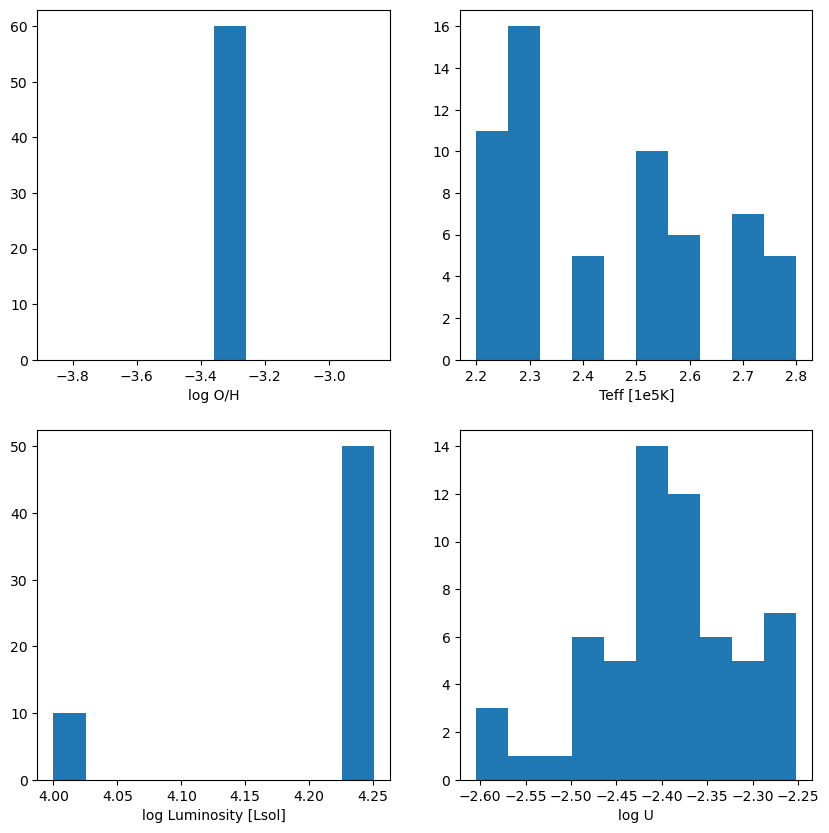

In [7]:
# Let's do some histograms of the 60 best models
res2 = res[0:60]
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.hist(res2['O'])
ax1.set_xlabel('log O/H')
ax2.hist(res2['teff']/1e5)
ax2.set_xlabel('Teff [1e5K]')
ax3.hist(res2['lumi'])
ax3.set_xlabel('log Luminosity [Lsol]')
ax4.hist(res2['logU_mean'])
ax4.set_xlabel('log U');

In [8]:
# Let's choose one model and use its name and ID from 3MdB.
print(res.loc[6])
model_name=res.loc[6]['file']
model_ID = int(res.loc[6]['ID'])
print(model_ID)

ID               140705
file         BB_C_21226
O                 -3.36
N                 -3.75
logU_mean      -2.28945
Hbfrac              1.0
teff           180000.0
lumi           3.748188
dens                3.0
radius             17.0
HeII           0.459453
RO             0.011869
RS            18.666602
RO3            0.013396
RN2            0.020837
O3            11.713851
N2             2.844986
khi2           2.286681
Name: 6, dtype: object
140705


In [9]:
# All the 3MdB fields can be download using the N ID
with sqlEngine.connect() as db_con:
    MdB_model = pd.read_sql(f"SELECT * from tab_17 where N = {model_ID}", con=db_con)

print(MdB_model)

        N    user date_submitted date_running       ref        file  \
0  140705  Gloria           None         None  PNe_2020  BB_C_21226   

         dir C_version geom    atm_cmd  ...            datetime  N_pending  \
0  PNe_2020/     17.01       Blackbody  ... 2020-02-21 05:00:43      21226   

      host N1 N2   W1  Radio_2.5GHz  Radio_4.9GHz   Radio_12GHz   Radio_20GHz  
0  nefeles -1 -1  1.0  3.264710e-39  1.254290e-38  7.523920e-38  2.089400e-37  

[1 rows x 765 columns]


In [10]:
# Connect to 3MdB

from pyCloudy.db.use3MdB import print_input
OVN_dic = {'host' : host, 
       'user_name' : user,
       'user_passwd' : passwd,
       'base_name' : db,
       'pending_table' : '`pending`',
       'master_table' : '`tab_17`',
       'teion_table' : '`teion_17`',
       'abion_table' : '`abion_17`',
       'temis_table' : '`temis_17`',
       'lines_table' : '`lines_17`',
       'seds_table': '`seds`' 
       }
# Generate the input file for Cloudy from the 3MdB record
print_input(model_ID, OVN_dic=OVN_dic, read_tab=True, dir='../models')
print(f'../models/{model_name}.in')

../models/BB_C_21226.in


In [11]:
!cat '../models/BB_C_21226.in'

#####################################
title BB_C_21226
#####################################
set punch prefix "BB_C_21226"
Blackbody  180000.0
luminosity total solar = 3.748
radius = 17.000
hden = 3.000
filling factor = 1.000000
element abundance helium -1.000
element abundance lithium -8.690
element abundance beryllium -10.670
element abundance boron -9.210
element abundance carbon -3.110
element abundance nitrogen -3.750
element abundance oxygen -3.360
element abundance fluorine -6.500
element abundance neon -3.960
element abundance sodium -5.700
element abundance magnesium -5.800
element abundance aluminium -6.570
element abundance silicon -5.000
element abundance phosphorus -6.700
element abundance sulphur -5.000
element abundance chlorine -6.770
element abundance argon -5.570
element abundance potassium -6.900
element abundance calcium -7.900
element abundance scandium -8.830
element abundance titanium -6.980
element abundance vanadium -8.000
element abundance chromium -6.330
elem

The following does not work unless some edits in the input file are performed: remove 3 lines with only numbers on them, and all the emission lines with N at the end (they are computed by PyNeb in 3MdB).
And if using Cloudy 17 input for running Cloudy 23 or more, this will not work, as line labels changed. 
You may also need to remove lines ending with "N".

I will correct this one of these days...

In [19]:
pc.config.cloudy_exe = '/usr/local/Cloudy/c17.03/source/cloudy.exe'
pc.run_cloudy(dir_ = '../models/', n_proc = 1, use_make = False, model_name = model_name)

In [21]:
# Read the cloudy model into a CloudyModel object
M = pc.CloudyModel(f'../models/{model_name}')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [15]:
M.print_stats()

 Name of the model: ../models/BB_C_864370
 R_in (cut) = 1.000e+16 (1.000e+16), R_out (cut) = 2.936e+18 (2.936e+18)
 H+ mass = 1.00e+01, H mass = 2.68e+01 N zones: 406
 <H+/H> = 0.80, <He++/He> = 0.53, <He+/He> = 0.34
 <O+++/O> = 0.19, <O++/O> = 0.29, <O+/O> = 0.16
 <N+++/O> = 0.19, <N++/O> = 0.31, <N+/O> = 0.21
 T(O+++) = 14428, T(O++) = 13302, T(O+) = 11519
 <ne> = 133,  <nH> = 300, T0 = 12728, t2=0.0626
 <log U> = -2.71


In [16]:
M.emis_labels

array(['BAC___3646A', 'COUT__3646A', 'CREF__3646A', 'H__1__4861A',
       'TOTL__4861A', 'H__1__6563A', 'H__1__4340A', 'H__1__4102A',
       'H__1__3970A', 'H__1__3835A', 'H__1__1216A', 'H__1_4051M',
       'H__1_2625M', 'H__1_7458M', 'HE_1__5876A', 'CA_B__5876A',
       'HE_1__7281A', 'HE_1__7065A', 'HE_1__4471A', 'CA_B__4471A',
       'HE_1__6678A', 'CA_B__6678A', 'TOTL_1083M', 'HE_2__1640A',
       'HE_2__4686A', 'C__1__8727A', 'TOTL__9850A', 'C_IC__9850A',
       'TOTL__2326A', 'C__2__1335A', 'C__2__1761A', 'TOTL__6580A',
       'C__2__4267A', 'C__2_1576M', 'C__3_9770A', 'C__3__1907A',
       'C__3__1910A', 'C__3__4649A', 'C__3__2297A', 'TOTL__1549A',
       'C__4__1549A', 'C__4__4659A', 'N__1__5198A', 'N__1__5200A',
       'N__2__5755A', 'N_2R__5755A', 'N__2__6548A', 'N__2__6584A',
       'N__2__2141A', 'N__2__4239A', 'N__2__4041A', 'TOTL__5679A',
       'N__2_1217M', 'N__2_2054M', 'N__3_5721M', 'N__3__4641A',
       'TOTL__1750A', 'N__3__4379A', 'N__4__1485A', 'N__4__1719A',
    

In [53]:
def compare_obs(M, label, obs_value):
    print('{} {:6.1f} {:6.1f}'.format(label, obs_value,M.get_emis_vol(label)/M.get_emis_vol('H__1__4861A')*100))

In [54]:
# This will compare the model and the results
print('LINE          OBS   MODEL')
compare_obs(M, 'O_II__3726A', 333)
compare_obs(M, 'O_II__3729A', 333)
compare_obs(M, 'NE_3__3869A', 135)
compare_obs(M, 'TOTL__4363A', 28)
compare_obs(M, 'HE_2__4686A', 70)
compare_obs(M, 'O__3__5007A', 854)
compare_obs(M, 'N__2__5755A', 8.5)
compare_obs(M, 'HE_1__5876A', 11)
compare_obs(M, 'S__3__6312A', 5.9)
compare_obs(M, 'N__2__6584A', 453)
compare_obs(M, 'S_II__6716A', 49)
compare_obs(M, 'S_II__6731A', 40)
compare_obs(M, 'AR_3__7135A', 19)
compare_obs(M, 'O_II__7323A', 4.7)
compare_obs(M, 'O_II__7332A', 3.1)
O3 = pn.Atom('O',3)
N2 = pn.Atom('N',2)
T_O3_obs = O3.getTemDen(28./854, den=300., wave1=4363, wave2=5007)
T_O3_mod = O3.getTemDen(M.get_emis_vol('TOTL__4363A')/M.get_emis_vol('O__3__5007A'), den=300., wave1=4363, wave2=5007)
print('Te(OIII)    {:6.0f} {:6.0f}'.format(T_O3_obs, T_O3_mod))
T_N2_obs = N2.getTemDen(8.5/453, den=300., wave1=5755, wave2=6584)
T_N2_mod = N2.getTemDen(M.get_emis_vol('N__2__5755A')/M.get_emis_vol('N__2__6584A'), den=300., wave1=5755, wave2=6584)
print('Te(NII)     {:6.0f} {:6.0f}'.format(T_N2_obs, T_N2_mod))
print('Compare the electron temeprature in the N+ and O++ regions...')

LINE          OBS   MODEL
O_II__3726A  333.0  205.8
O_II__3729A  333.0  247.1
NE_3__3869A  135.0  163.4
TOTL__4363A   28.0   16.4
HE_2__4686A   70.0   73.0
O__3__5007A  854.0 1045.7
N__2__5755A    8.5    7.7
HE_1__5876A   11.0    6.4
S__3__6312A    5.9    6.4
N__2__6584A  453.0  379.6
S_II__6716A   49.0   61.1
S_II__6731A   40.0   51.3
AR_3__7135A   19.0   26.7
O_II__7323A    4.7    6.9
O_II__7332A    3.1    5.6
Te(OIII)     19702  13643
Te(NII)      10980  11353
Compare the electron temeprature in the N+ and O++ regions...


In [54]:
co.close()